In [1]:
# Import libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

Read all of our data in as a pandas data frame

In [3]:
allData = pd.read_csv("../Data/CSV/games.csv")
allData.describe()

,id,year,ratingScore,ratingCount,ratingStdDev,weightAvg,weightLightPct,weightMediumLightPct,weightMediumPct,weightMediumHeavyPct,weightHeavyPct,playerAgeMin,playtimeMin,playtimeMax,playersStatedMin,playersStatedMax,playersBestMin,playersBestMax,priceAverage,priceStdDev,
count,84593.000000,84593.000000,84593.000000,84593.000000,84593.000000,84593.000000,71714.000000,71714.000000,71714.000000,71714.000000,71714.000000,84593.000000,84593.000000,84593.000000,84593.00000,84593.000000,84593.000000,84593.000000,19461.000000,19461.000000,...
mean,80013.233152,1807.385008,4.279174,110.736988,0.774242,0.876848,19.957703,16.550744,10.183793,3.200719,1.401069,7.019162,47.198243,51.168395,1.98825,5.682491,2.219664,5.263934,24.716603,7.954304,...
std,63960.226532,588.475029,3.039157,929.482652,0.814887,1.160127,35.385330,29.738281,23.392949,12.743502,8.428136,6.808049,327.225953,341.891784,0.92677,55.144456,1.210552,54.600688,33.740133,16.690697,...
min,1.000000,-3500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.010000,0.000000,...
25%,23001.000000,1985.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,5.000000,2.00000,2.000000,2.000000,2.000000,9.950000,0.000000,...
50%,60049.000000,2004.000000,5.333330,2.000000,0.695211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,30.000000,30.000000,2.00000,4.000000,2.000000,4.000000,16.663333,3.925003,...
75%,139950.000000,2011.000000,6.716100,15.000000,1.419710,1.785700,25.000000,25.000000,0.000000,0.000000,0.000000,12.000000,60.000000,60.000000,2.00000,6.000000,2.000000,6.000000,29.084300,9.479418,...
max,202858.000000,2018.000000,10.000000,59423.000000,4.500000,5.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1333.000000,60120.000000,60120.000000,99.00000,11299.000000,99.000000,11299.000000,1300.000000,581.085046,...


Subset the data to remove some rows with missing feature values

In [4]:
len(allData)

84593

In [5]:
allWithoutNA = allData.dropna()
len(allWithoutNA)

19095

In [6]:
since1950 = allWithoutNA.query("year >= 1950")
len(since1950)

18799

In [7]:
atLeastThreeRaters = since1950.query("ratingCount > 2")
len(atLeastThreeRaters)

18141

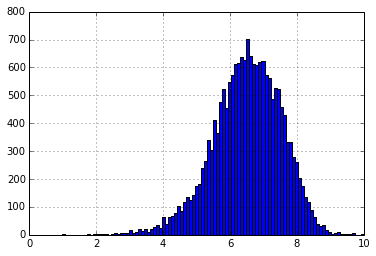

In [16]:
atLeastThreeRaters.ratingScore.hist(bins=100)

In [20]:
df = atLeastThreeRaters

In [25]:
# Extract feature (X) and target (y) columns
excluded = ["id", "name", "url", "ratingScore", "ratingCount", "ratingStdDev"]
feature_cols = [col for col in df.columns if col not in excluded]
target_col = "ratingScore" # This is our target

X_all = df[feature_cols]  # feature values for all students
y_all = df[target_col]  # corresponding targets/labels
print "\nFeature values:-"
print X_all.head()  # print the first 5 rows


Feature values:-
   year  weightAvg  weightLightPct  weightMediumLightPct  weightMediumPct  \
0  1986     4.3436        0.420757              0.841515        11.500701   
1  1981     1.9423       21.153846             65.384615        11.538462   
2  1998     2.5079        6.067416             43.895131        43.820225   
3  1992     2.6667        6.666667             33.333333        46.666667   
4  1964     2.5128        5.906040             43.422819        45.033557   

   weightMediumHeavyPct  weightHeavyPct  playerAgeMin  playtimeMin  \
0             38.429173       48.807854            14          240   
1              1.923077        0.000000            12           30   
2              5.617978        0.599251            10           30   
3             13.333333        0.000000            12           60   
4              4.765101        0.872483            12           90   

   playtimeMax  playersStatedMin  playersStatedMax  playersBestMin  \
0          240              

In [27]:
# First, decide how many training vs test samples you want
num_all = df.shape[0]  # same as len(student_data)
num_train = int(0.8 * num_all)  # 80% of the data for training

# Select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=num_train, random_state=12)

print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

Training set: 14512 samples
Test set: 3629 samples


In [31]:
# Train a model
import time

def train_regressor(reg, X_train, y_train):
    print "Training {}...".format(reg.__class__.__name__)
    start = time.time()
    reg.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)

# TODO: Choose a model, import it and instantiate an object
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators=2000, min_samples_split=5, random_state=12)

# Fit model to training data
train_regressor(reg, X_train, y_train)  # note: using entire training set here
print reg  # you can inspect the learned model by printing it

Training RandomForestRegressor...
Done!
Training time (secs): 513.436
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=2000, n_jobs=1, oob_score=False, random_state=12,
           verbose=0, warm_start=False)


In [97]:
from sklearn.metrics import cohen_kappa_score, confusion_matrix, mean_squared_error
def predict(reg, features, target):
    print "Predicting labels using {}...".format(reg.__class__.__name__)
    start = time.time()
    y_pred = reg.predict(features)
    end = time.time()
    print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return pd.Series(y_pred)

y_train_pred = predict(reg, X_train, y_train)
y_test_pred  = predict(reg, X_test, y_test)

Predicting labels using RandomForestRegressor...
Done!
Prediction time (secs): 7.664
Predicting labels using RandomForestRegressor...
Done!
Prediction time (secs): 1.961


In [98]:
print "Mean Squared Error (train): {}".format(mean_squared_error(y_train, y_train_pred))
print "Mean Squared Error (test) : {}".format(mean_squared_error(y_test,  y_test_pred))

Mean Squared Error (train): 0.0753190944204
Mean Squared Error (test) : 0.401570723774


In [99]:
print "Confusion matrix (train):\n{}".format(confusion_matrix(np.rint(y_train), np.rint(y_train_pred), labels=range(0,11)))
print "Confusion matrix (test):\n{}".format(confusion_matrix(np.rint(y_test), np.rint(y_test_pred), labels=range(0,11)))

Confusion matrix (train):
[[   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    6    8    0    0    0    0    0    0]
 [   0    0    0    0   78   12    0    0    0    0    0]
 [   0    0    0    0  117  299    1    0    0    0    0]
 [   0    0    0    0    0 1193  512    0    0    0    0]
 [   0    0    0    0    0  155 4244  381    0    0    0]
 [   0    0    0    0    0    0  543 4509   84    0    0]
 [   0    0    0    0    0    0    4  573 1636    5    0]
 [   0    0    0    0    0    0    0    5   95   43    0]
 [   0    0    0    0    0    0    0    0    1    2    6]]
Confusion matrix (test):
[[  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   1   2   2   0   0   0   0]
 [  0   0   0   0   0  11   6   0   0   0   0]
 [  0   0   0   0   1  82  37   1   0   0   0]
 [  0   0   0   0   1 176 205  23   1   0   0]
 [  0   0   0   0   0 116 77

In [100]:
from sklearn.metrics import accuracy_score, f1_score
print "Exact agreement (train): {}".format(accuracy_score(np.rint(y_train), np.rint(y_train_pred)))
print "Exact agreement (test) : {}".format(accuracy_score(np.rint(y_test), np.rint(y_test_pred)))

Exact agreement (train): 0.80953693495
Exact agreement (test) : 0.585285202535


In [101]:
print "F1 Score (train): {}".format(f1_score(np.rint(y_train), np.rint(y_train_pred), average='weighted'))
print "F1 Score (test) : {}".format(f1_score(np.rint(y_test), np.rint(y_test_pred), average='weighted'))

F1 Score (train): 0.801264091058
F1 Score (test) : 0.569936147581


In [102]:
from scipy.stats import pearsonr
print "Pearson Correlation (train): {}".format(pearsonr(y_train, y_train_pred)[0])
print "Pearson Correlation (test) : {}".format(pearsonr(y_test, y_test_pred)[0])

Pearson Correlation (train): 0.969819085363
Pearson Correlation (test) : 0.790170700113
